# Chernoff bound

The Chernoff bound, named after Herman Chernoff but due to Herman Rubin,[1] gives exponentially decreasing bounds on tail distributions of sums of independent random variables. It is a sharper bound than the known first- or second-moment-based tail bounds such as Markov's inequality or Chebyshev's inequality, which only yield power-law bounds on tail decay. However, the Chernoff bound requires that the variates be independent – a condition that neither Markov's inequality nor Chebyshev's inequality require, although Chebyshev's inequality does require the variates to be pairwise independent.

The generic Chernoff bound for a random variable $X$ is attained by applying Markovs inequality to $e^{t X[2]}$ For every $t>0$ :
$$
\operatorname{Pr}(X \geq a)=\operatorname{Pr}\left(e^{t \cdot X} \geq e^{t \cdot a}\right) \leq \frac{\mathrm{E}\left[e^{t \cdot X}\right]}{e^{t \cdot a}}
$$
When $X$ is the sum of $n$ random variables $X_{1}, \ldots, X_{n}$, we get for any $t>0$
$$
\operatorname{Pr}(X \geq a) \leq e^{-t a} \mathrm{E}\left[\prod_{i} e^{t \cdot X_{i}}\right]
$$
In particular, optimizing over $t$ and assuming that $X_{i}$ are independent, we obtain,
$$
\operatorname{Pr}(X \geq a) \leq \min _{t>0} e^{-t a} \prod_{i} \mathrm{E}\left[e^{t X_{i}}\right]
$$
Similarly,
$$
\operatorname{Pr}(X \leq a)=\operatorname{Pr}\left(e^{-t X} \geq e^{-t a}\right)
$$
and so,
$$
\operatorname{Pr}(X \leq a) \leq \min _{t>0} e^{t a} \prod_{i} \mathrm{E}\left[e^{-t X_{i}}\right]
$$
Specific Chernoff bounds are attained by calculating $\mathrm{E}\left[e^{-t \cdot X_{i}}\right]$ for specific instances of the basic variables $X_{i}$.

In [1]:
# Figure 7.8, page 384.
# Chernoff lower bound.

from cvxopt import matrix, mul, exp, normal, solvers, blas
solvers.options['show_progress'] = False

In [4]:
# Extreme points and inequality description of Voronoi region around
# first symbol (at the origin).
m = 6
V = matrix([ 1.0,  1.0,
            -1.0,  2.0,
            -2.0,  1.0,
            -2.0, -1.0,
             0.0, -2.0,
             1.5, -1.0,
             1.0,  1.0 ], (2,m+1))

# A and b are lists with the inequality descriptions of the regions.
A = [ matrix( [-(V[1,:m] - V[1,1:]), V[0,:m] - V[0,1:]] ).T ]
b = [ mul(A[0], V[:,:m].T) * matrix(1.0, (2,1)) ]

# List of symbols.
C = [ matrix(0.0, (2,1)) ] + \
    [ 2.0 * b[0][k] / blas.nrm2(A[0][k,:])**2 * A[0][k,:].T for k in
    range(m) ]

In [5]:
# Voronoi set around C[1]
A += [ matrix(0.0, (3,2)) ]
b += [ matrix(0.0, (3,1)) ]
A[1][0,:] = -A[0][0,:]
b[1][0] = -b[0][0]
A[1][1,:] = (C[m] - C[1]).T
b[1][1] = 0.5 * A[1][1,:] * ( C[m] + C[1] )
A[1][2,:] = (C[2] - C[1]).T
b[1][2] = 0.5 * A[1][2,:] * ( C[2] + C[1] )

In [6]:
# Voronoi set around C[2], ..., C[5]
for k in range(2, 6):
    A += [ matrix(0.0, (3,2)) ]
    b += [ matrix(0.0, (3,1)) ]
    A[k][0,:] = -A[0][k-1,:]
    b[k][0] = -b[0][k-1]
    A[k][1,:] = (C[k-1] - C[k]).T
    b[k][1] = 0.5 * A[k][1,:] * ( C[k-1] + C[k] )
    A[k][2,:] = (C[k+1] - C[k]).T
    b[k][2] = 0.5 * A[k][2,:] * ( C[k+1] + C[k] )

In [7]:
# Voronoi set around C[6]
A += [ matrix(0.0, (3,2)) ]
b += [ matrix(0.0, (3,1)) ]
A[6][0,:] = -A[0][5,:]
b[6][0] = -b[0][5]
A[6][1,:] = (C[1] - C[6]).T
b[6][1] = 0.5 * A[6][1,:] * ( C[1] + C[6] )
A[6][2,:] = (C[5] - C[6]).T
b[6][2] = 0.5 * A[6][2,:] * ( C[5] + C[6] )

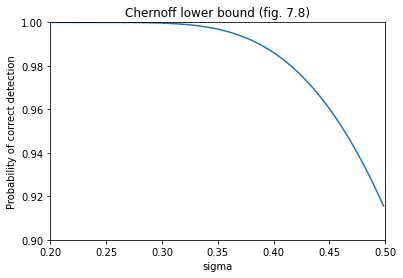

In [8]:
# For regions k=1, ..., 6, let pk be the optimal value of
#
#     minimize    x'*x
#     subject to  A*x <= b.
#
# The Chernoff upper bound is  1.0 - sum exp( - pk / (2 sigma^2)).

P = matrix([1.0, 0.0, 0.0, 1.0], (2,2))
q = matrix(0.0, (2,1))
optvals = matrix([ blas.nrm2( solvers.qp(P, q, A[k], b[k] )['x'] )**2
    for k in range(1,7) ])
nopts = 200
sigmas = 0.2 + (0.5 - 0.2)/nopts * matrix(list(range(nopts)), tc='d')
bnds = [ 1.0 - sum( exp( - optvals / (2*sigma**2) )) for sigma
    in sigmas]

try: import pylab
except ImportError: pass
else:
    pylab.figure(facecolor='w')
    pylab.plot(sigmas, bnds, '-')
    pylab.axis([0.2, 0.5, 0.9, 1.0])
    pylab.title('Chernoff lower bound (fig. 7.8)')
    pylab.xlabel('sigma')
    pylab.ylabel('Probability of correct detection')
    pylab.show()

    if 0:  # uncomment out for the Monte Carlo estimation.
        N = 100000
        mcest = []
        ones = matrix(1.0, (1,m))
        for sigma in sigmas:
            X = sigma * normal(2, N)
            S = b[0][:,N*[0]] - A[0]*X
            S = ones * (S - abs(S))
            mcest += [ N - len(filter(lambda x: x < 0.0, S)) ]

        pylab.figure(facecolor='w')
        pylab.plot(sigmas, bnds, '-', sigmas, (1.0/N)*matrix(mcest), '--')
        pylab.plot(sigmas, bnds, '-')
        pylab.axis([0.2, 0.5, 0.9, 1.0])
        pylab.title('Chernoff lower bound (fig. 7.8)')
        pylab.xlabel('sigma')
        pylab.ylabel('Probability of correct detection')
        pylab.show()

1. $^{\wedge}$ Chernoff, Herman $(2014) .$ "A career in statistics" $\triangle(P D F) . I n$ Lin, Xihong; Genest, Christian; Banks, David L.; Molenberghs, Geert; Scott, David W.; Wang, Jane-Ling (eds.). Past, Present, and Future of Statistics $B$. CRC Press. p. 35 .
ISBN 9781482204964 .